In [1]:
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from astropy.io import ascii
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
#from astropy.cosmology import Planck18 as cosmo
import pandas as pd
import pprint
import sys
import operator
from scipy import optimize
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71, Om0=0.27)
import seaborn as sbrn
from scipy.spatial.distance import cdist, euclidean
import cmastro.cm as cma
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['figure.dpi'] = 300

In [2]:
col_list = ['objname','f','f_f125w','z','UV','VJ','mag_f125w','mag_f160w','re','dre','re_f125w','dre_f125w','FAST_lmass','logstellar_mass_median','logstellar_mass_errup','logstellar_mass_errdown','sfr_100myr_median','sfr_100myr_errup','sfr_100myr_errdown','logssfr_100myr_median','logssfr_100myr_errup','logssfr_100myr_errdown']

file = ascii.read("prospector_UVJ_galfit_FAST_ERRCORR.csv", format='csv')
data = pd.read_csv('prospector_UVJ_galfit_FAST_ERRCORR.csv', index_col=0, usecols=col_list)

data.rename(columns={'f':'Flag_f160w', 'f_f125w':'Flag_f125w', 're':'R_f160w', 'dre':'dR_f160w', 're_f125w':'R_f125w', 'dre_f125w':'dR_f125w', 'logstellar_mass_median':'lmass', 'logstellar_mass_errup':'lmass_high', 'logstellar_mass_errdown':'lmass_low', 'logssfr_100myr_median':'lssfr', 'logssfr_100myr_errup':'lssfr_high', 'logssfr_100myr_errdown':'lssfr_low'}, inplace=True)

def calc_arcrad_5000(row):
    if row['z'] <= 1.5:
        return row['R_f125w']*((1+row['z'])/(1+1.5))**(-0.35+0.12*row['z']-0.25*(row['lmass']/10))
    else:
        return row['R_f160w']*((1+row['z'])/(1+1.5))**(-0.35+0.12*row['z']-0.25*(row['lmass']/10))

def calc_arcrad_5000_err(row):
    if row['z'] <= 1.5:
        return row['dR_f125w']*((1+row['z'])/(1+1.5))**(-0.35+0.12*row['z']-0.25*(row['lmass']/10))
    else:
        return row['dR_f160w']*((1+row['z'])/(1+1.5))**(-0.35+0.12*row['z']-0.25*(row['lmass']/10))

def calc_flags(row):
    if row['z'] <= 1.5:
        return row['Flag_f125w']
    else:
        return row['Flag_f160w']

    
data['lmass_errup'] = data['lmass_high']-data['lmass']
data['lmass_errdown'] = data['lmass']-data['lmass_low']
data['lssfr_errup'] = data['lssfr_high']-data['lssfr']
data['lssfr_errdown'] = data['lssfr']-data['lssfr_low']
data['arcrad_5000'] = data.apply(calc_arcrad_5000, axis=1)
data['arcrad_5000_err'] = data.apply(calc_arcrad_5000_err, axis=1)
data['flags'] = data.apply(calc_flags, axis=1)
data['lR_eff'] = np.log10(data['arcrad_5000']*(cosmo.kpc_proper_per_arcmin(data['z'].to_numpy())/60).value)
data['lR_eff_err'] = 0.434*(data['arcrad_5000_err']/data['arcrad_5000'])
data = data[(data['flags'] <= 1.0) & (data['lmass'] >= 9.0)]

print(data)

           Flag_f160w  Flag_f125w       z        UV        VJ   R_f160w  \
objname                                                                   
AEGIS_13          0.0         1.0  1.3049  1.651843  1.903840  0.388926   
AEGIS_17          0.0         1.0  1.7499  1.475649  1.328187  0.233094   
AEGIS_19          0.0         0.0  1.0761  0.680207  0.711274  0.316938   
AEGIS_22          0.0         0.0  1.6570  0.835242  1.123700  0.094710   
AEGIS_27          2.0         0.0  0.6806  0.732008  0.799708  0.223662   
...               ...         ...     ...       ...       ...       ...   
UDS_44043         0.0         1.0  1.3178  0.472340  0.637036  0.102978   
UDS_44056         0.0         2.0  2.1917  1.318468  1.410149  0.360240   
UDS_44060         0.0         1.0  1.6987  0.395816  0.130681  0.092310   
UDS_44077         1.0         0.0  1.1105  0.727672  0.592051  0.245802   
UDS_44090         0.0         0.0  1.4365  0.674018  0.604624  0.101502   

           dR_f160w   R_

/Users/leo/Library/Python/3.8/lib/python/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
starforming_criteria = ((data['UV']<1.3)|(data['VJ']>1.6)|(data['UV']<(0.88*data['VJ']+0.69)))
quiescent_criteria = (data['UV']>1.3)&(data['VJ']<1.6)&(data['UV']>(0.88*data['VJ']+0.69))

zbins = [(data['z']>=0.5) & (data['z']<1.0), (data['z']>=1.0) & (data['z']<1.5), (data['z']>=1.5) & (data['z']<2.0), (data['z']>=2)]
completeness50_q = [(data['lmass']>9.2), (data['lmass']>9.67), (data['lmass']>9.9), (data['lmass']>10.33)]
completeness50_sf = [(data['lmass']>9.0), (data['lmass']>9.29), (data['lmass']>9.5), (data['lmass']>9.63)]

quiescent = []
quiescent_vdw = []
starforming = []
starforming_vdw = []
fullsample50 = []


for z in range(4):
    quiescent.append(data[(quiescent_criteria) & zbins[z] & completeness50_q[z]])
    quiescent_vdw.append(data[(quiescent_criteria) & zbins[z] & (data['FAST_lmass']>10.3)])
    starforming.append(data[(starforming_criteria) & zbins[z] & completeness50_sf[z]])
    starforming_vdw.append(data[(starforming_criteria) & zbins[z] & (data['FAST_lmass']>10.3)])
    fullsample50.append(pd.concat([starforming[z],quiescent[z]]))

print(fullsample50[0])

           Flag_f160w  Flag_f125w       z        UV        VJ    R_f160w  \
objname                                                                    
AEGIS_27          2.0         0.0  0.6806  0.732008  0.799708   0.223662   
AEGIS_55          0.0         0.0  0.6970  0.839251  0.578775   0.412968   
AEGIS_83          0.0         0.0  0.7250  0.774377  0.690601   0.343890   
AEGIS_138         2.0         1.0  0.5666  0.778202  0.655712  24.000000   
AEGIS_145         0.0         0.0  0.7842  0.668164  0.311414   0.604266   
...               ...         ...     ...       ...       ...        ...   
UDS_40342         1.0         1.0  0.6446  1.838143  1.273033   0.194952   
UDS_40669         1.0         1.0  0.5865  2.094513  1.496819   1.391920   
UDS_40854         0.0         0.0  0.5744  1.835023  1.245278   0.347250   
UDS_41086         1.0         1.0  0.6154  1.923378  1.391674   0.469338   
UDS_41095         1.0         1.0  0.7577  1.833536  1.218601   0.230826   

           

In [4]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    #plt.register_cmap(cmap=newcmap)

    return newcmap


map1 = plt.cm.OrRd_r(np.linspace(0., 1, 128))
map2 = plt.get_cmap(name='cma:laguna_r')(np.linspace(0, 1, 128))

# combine them and build a new colormap
comb_map = np.vstack((map1, map2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', comb_map)
#cmap = shiftedColorMap(mymap, midpoint=0.5)
cmap = plt.cm.RdYlBu
#cNorm  = colors.Normalize(vmin=min(min(x) for x in fullsample50['lmass']), vmax=max(max(x) for x in fullsample50['lmass']))

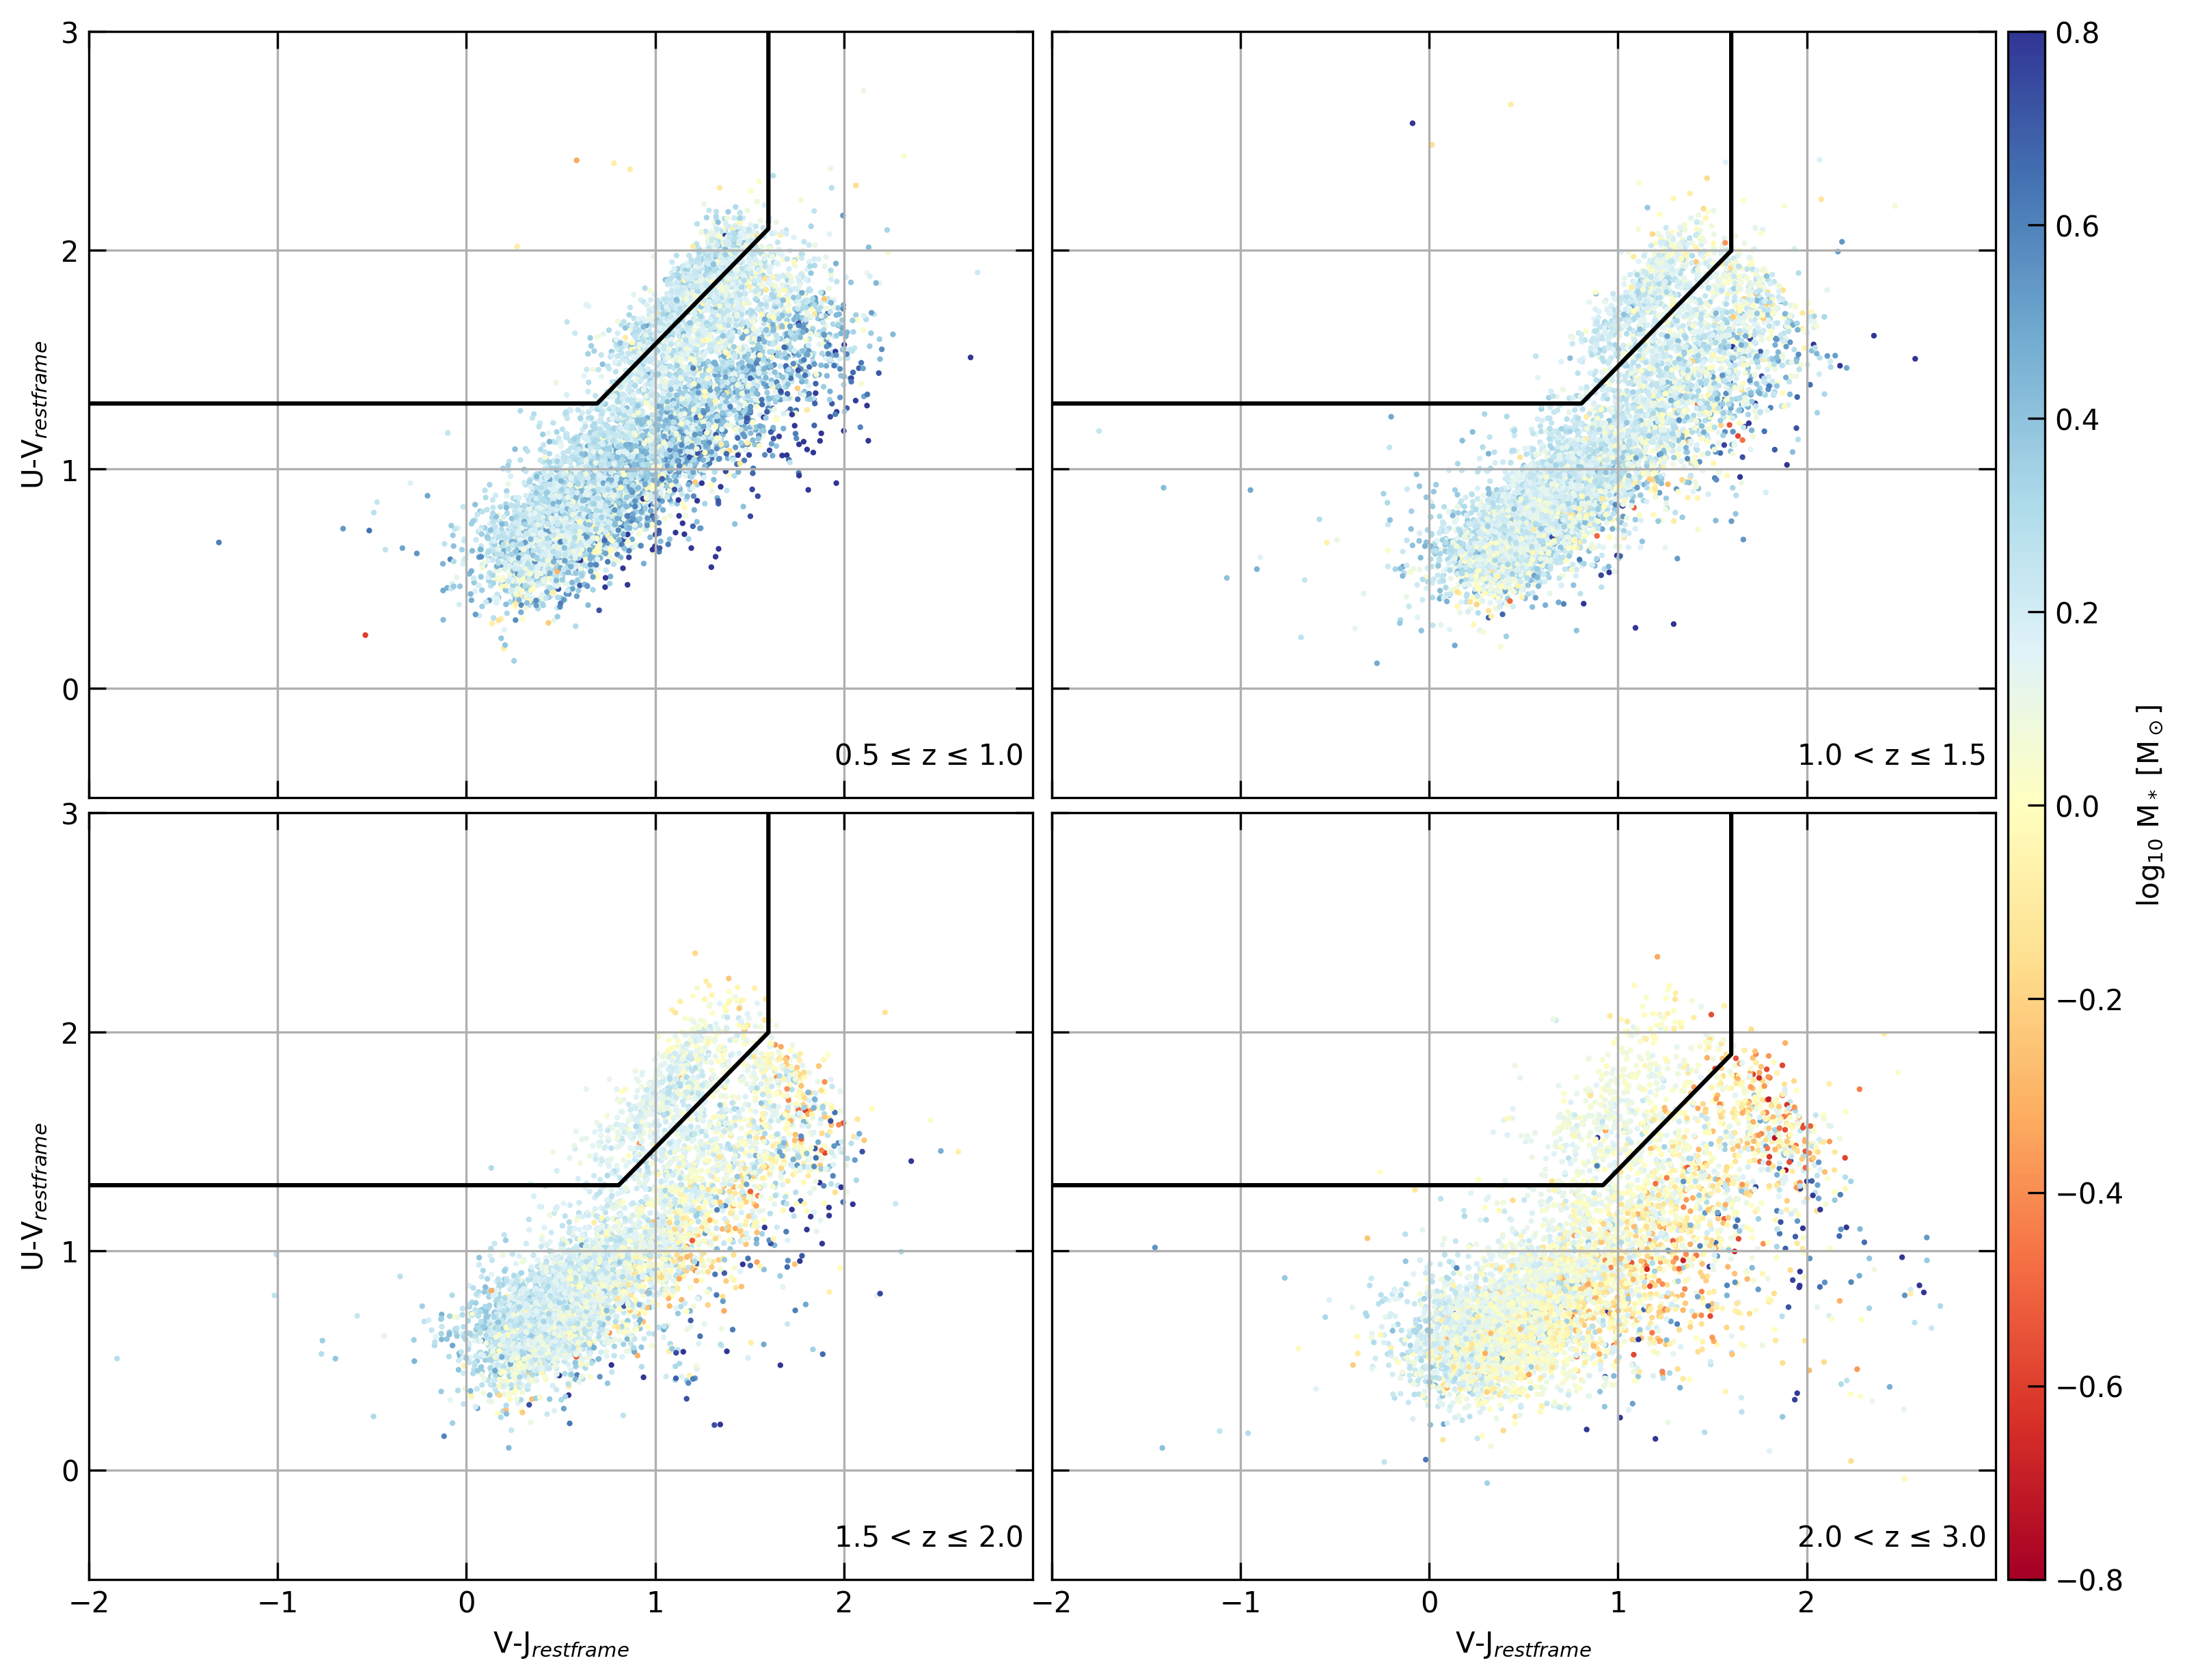

In [5]:
cut_VJ = []
cut_UV = []
cut_VJ.append([-10.,0.693182,1.6,1.6])
cut_VJ.append([-10.,0.806818,1.6,1.6])
cut_VJ.append([-10.,0.806818,1.6,1.6])
cut_VJ.append([-10.,0.920455,1.6,1.6])
cut_UV.append([1.3,1.3,2.098,5])
cut_UV.append([1.3,1.3,1.998,5])
cut_UV.append([1.3,1.3,1.998,5])
cut_UV.append([1.3,1.3,1.898,5])

min_c = min(fullsample50[z]['lmass']-fullsample50[z]['FAST_lmass'])
max_c = max(fullsample50[z]['lmass']-fullsample50[z]['FAST_lmass'])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

for z in range(4):
    sc = ax[x[z],y[z]].scatter(fullsample50[z]['VJ'],fullsample50[z]['UV'],s=1,c=(fullsample50[z]['lmass']-fullsample50[z]['FAST_lmass']),cmap=cmap,vmin=-0.8,vmax=0.8)
    ax[x[z],y[z]].plot(cut_VJ[z],cut_UV[z],c="black")
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    if z == 0 or z == 2:
        ax[x[z],y[z]].set_yticks([0,1,2,3])
    else:
        ax[x[z],y[z]].set_xticks([-2,-1,0,1,2])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(-2,3)
    ax[x[z],y[z]].set_ylim(-0.5,3)
    ax[x[z],y[z]].text(1.95, -0.35,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('V-J$_{restframe}$')
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('U-V$_{restframe}$')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.1)
    ax[x[z],y[z]].grid()

cbar_ax = fig.add_axes([0.905, 0.125, 0.015, 0.755])
cbar = fig.colorbar(sc, cax=cbar_ax)

cbar
cbar.ax.set_ylabel('log$_{10}$ M$_*$ [M$_\odot$]')
cbar.ax.tick_params(direction='in', length=6)

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()

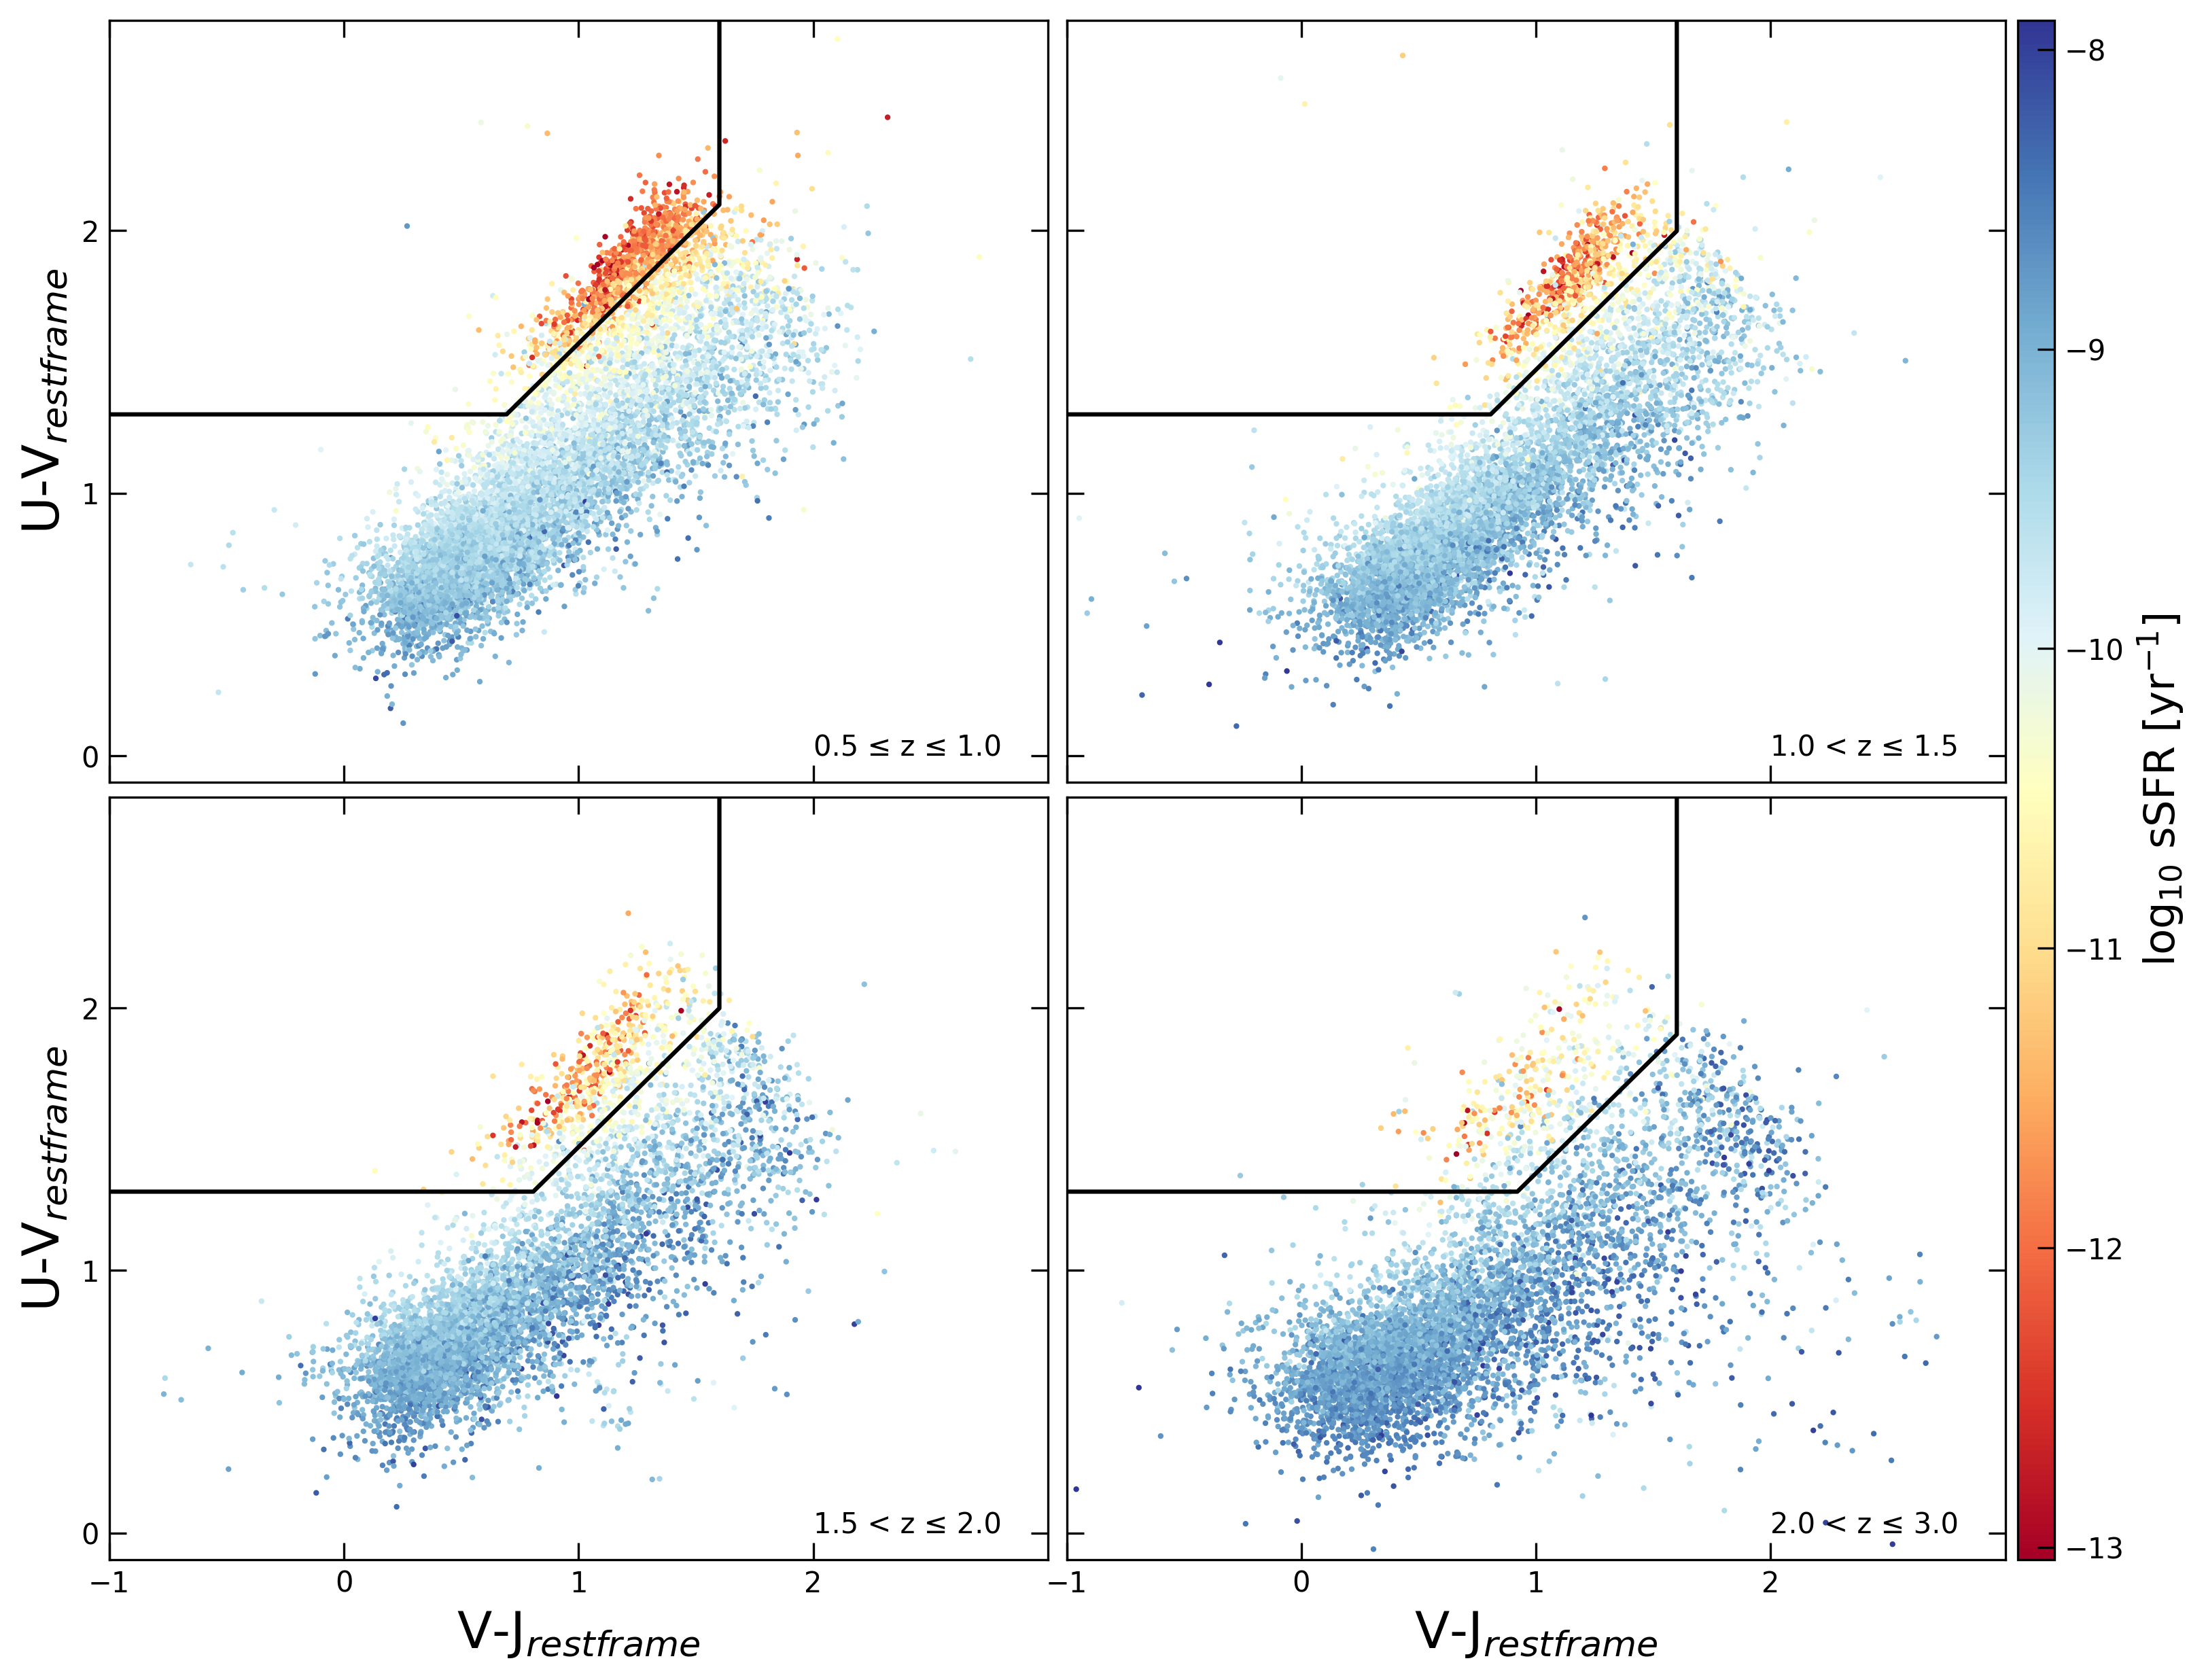

In [6]:
cut_VJ = []
cut_UV = []
cut_VJ.append([-10.,0.693182,1.6,1.6])
cut_VJ.append([-10.,0.806818,1.6,1.6])
cut_VJ.append([-10.,0.806818,1.6,1.6])
cut_VJ.append([-10.,0.920455,1.6,1.6])
cut_UV.append([1.3,1.3,2.098,5])
cut_UV.append([1.3,1.3,1.998,5])
cut_UV.append([1.3,1.3,1.998,5])
cut_UV.append([1.3,1.3,1.898,5])

min_c = min(fullsample50[z]['lssfr'])
max_c = max(fullsample50[z]['lssfr'])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

for z in range(4):
    sc = ax[x[z],y[z]].scatter(fullsample50[z]['VJ'],fullsample50[z]['UV'],s=1,c=fullsample50[z]['lssfr'],cmap='RdYlBu',vmin=min_c,vmax=max_c)
    ax[x[z],y[z]].plot(cut_VJ[z],cut_UV[z],c="black")
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    if z == 0 or z == 2:
        ax[x[z],y[z]].set_yticks([0,1,2,3])
    else:
        ax[x[z],y[z]].set_xticks([-2,-1,0,1,2])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(-1,3)
    ax[x[z],y[z]].set_ylim(-0.1,2.8)
    ax[x[z],y[z]].text(2, 0, zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('V-J$_{restframe}$', fontsize=18)
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('U-V$_{restframe}$', fontsize=18)

cbar_ax = fig.add_axes([0.905, 0.125, 0.015, 0.755])
cbar = fig.colorbar(sc, cax=cbar_ax)

cbar
cbar.ax.set_ylabel('log$_{10}$ sSFR [yr$^{-1}$]', fontsize=15)
cbar.ax.tick_params(direction='in', length=6)

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

In [7]:
M = []
R = []
SF = []

M.append(lmass[(redshift>=0.5)&(redshift<=1.0)])
M.append(lmass[(redshift>1.0)&(redshift<=1.5)])
M.append(lmass[(redshift>1.5)&(redshift<=2.0)])
M.append(lmass[(redshift>2.0)])
R.append(lR_eff[(redshift>=0.5)&(redshift<=1.0)])
R.append(lR_eff[(redshift>1.0)&(redshift<=1.5)])
R.append(lR_eff[(redshift>1.5)&(redshift<=2.0)])
R.append(lR_eff[(redshift>2.0)])
SF.append(lssfr[(redshift>=0.5)&(redshift<=1.0)])
SF.append(lssfr[(redshift>1.0)&(redshift<=1.5)])
SF.append(lssfr[(redshift>1.5)&(redshift<=2.0)])
SF.append(lssfr[(redshift>2.0)])
min_c = min(lssfr)
max_c = max(lssfr)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

for z in range(4):
    sc = ax[x[z],y[z]].scatter(M[z],R[z],s=3,c=SF[z],cmap='RdYlBu',vmin=min_c,vmax=max_c)
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    if z == 0 or z == 2:
        ax[x[z],y[z]].set_yticks([-1,0,1,2])
    else:
        ax[x[z],y[z]].set_xticks([8,9,10,11])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(7.5,12)
    ax[x[z],y[z]].set_ylim(-1.3,2.7)
    ax[x[z],y[z]].text(11.05, 2.5,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.1)
    ax[x[z],y[z]].grid()

cbar_ax = fig.add_axes([0.905, 0.125, 0.015, 0.755])
cbar = fig.colorbar(sc, cax=cbar_ax)

cbar
cbar.ax.set_ylabel('log$_{10}$ sSFR [yr$^{-1}$]')
cbar.ax.tick_params(direction='in', length=6)

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

NameError: name 'lmass' is not defined

In [ ]:
M_q = []
M_sf = []
R_q = []
R_sf = []

M_q.append(lmass[(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))])#&(lmass>9.0)]
M_sf.append(lmass[(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))])#&(lmass>8.6)]
M_q.append(lmass[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))])#&(lmass>9.4)]
M_sf.append(lmass[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))])#&(lmass>8.8)]
M_q.append(lmass[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))])#&(lmass>10.0)]
M_sf.append(lmass[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))])#&(lmass>9.4)]
M_q.append(lmass[(redshift>2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))])#&(lmass>10.0)]
M_sf.append(lmass[(redshift>2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))])#&(lmass>9.4)]
R_q.append(lR_eff[(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))])#&(lmass>9.0)]
R_sf.append(lR_eff[(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))])#&(lmass>8.6)]
R_q.append(lR_eff[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))])#&(lmass>9.4)]
R_sf.append(lR_eff[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))])#&(lmass>8.8)]
R_q.append(lR_eff[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))])#&(lmass>10.0)]
R_sf.append(lR_eff[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))])#&(lmass>9.4)]
R_q.append(lR_eff[(redshift>2)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))])#&(lmass>10.0)]
R_sf.append(lR_eff[(redshift>2)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))])#&(lmass>9.4)]

min_c = min(lssfr)
max_c = max(lssfr)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

for z in range(4):
    sc = ax[x[z],y[z]].scatter(M_sf[z],R_sf[z],s=2,c='blue',alpha=0.5,label='Star-forming')
    ax[x[z],y[z]].scatter(M_q[z],R_q[z],s=2,c='red',alpha=0.5,label='Quiescent')
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    if z == 0 or z == 2:
        ax[x[z],y[z]].set_yticks([-1,0,1,2])
    else:
        ax[x[z],y[z]].set_xticks([8,9,10,11])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(7.4,12)
    ax[x[z],y[z]].set_ylim(-1.3,2.7)
    ax[x[z],y[z]].text(11.05, -0.93,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.1)
    ax[x[z],y[z]].grid()
    if z == 2:
        ax[x[z],y[z]].legend()

linex = np.zeros(1000)
liney = np.linspace(-1.3,2.7,1000)
for i in range(len(linex)):
    linex[i] = 8.6
ax[0,0].plot(linex,liney,'--',c='blue')
for i in range(len(linex)):
    linex[i] = 9.0
ax[0,0].plot(linex,liney,'--',c='red')
for i in range(len(linex)):
    linex[i] = 8.8
ax[0,1].plot(linex,liney,'--',c='blue')
for i in range(len(linex)):
    linex[i] = 9.4
ax[0,1].plot(linex,liney,'--',c='red')
ax[1,0].plot(linex,liney,'--',c='blue')
for i in range(len(linex)):
    linex[i] = 10.0
ax[1,0].plot(linex,liney,'--',c='red')
for i in range(len(linex)):
    linex[i] = 9.4
ax[1,1].plot(linex,liney,'--',c='blue')
for i in range(len(linex)):
    linex[i] = 10.0
ax[1,1].plot(linex,liney,'--',c='red')

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()